# _Who Will Win Their Next Match_
### _The Pokemon Challenge - Machine Learning_
#### Jean-Sebastien Provost

In [1]:
    # Importing libraries

    import pandas as pd
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

In [2]:
    # Loading the dataset 
    pokemon = pd.read_csv("final_pokemon.csv")


In [3]:
    # Looking at the different features
    pokemon.columns.values

array(['Unnamed: 0', 'Loser', 'Winner', 'First_pokemon', 'Second_pokemon',
       'win', 'w_name', 'w_Type1', 'w_HP', 'w_attack', 'w_defense',
       'w_sp_atk', 'w_sp_def', 'w_Speed', 'w_Generation', 'w_Legendary',
       'w_wins', 'w_firstatk', 'w_firstdef', 'w_matches', 'w_watkfirst',
       'w_atksecond.x', 'w_probwatkfirst', 'w_probwsecond',
       'w_probWinning', 'l_name', 'l_Type1', 'l_HP', 'l_attack',
       'l_defense', 'l_sp_atk', 'l_sp_def', 'l_Speed', 'l_Generation',
       'l_Legendary', 'l_wins', 'l_firstatk', 'l_firstdef', 'l_matches',
       'l_watkfirst', 'l_atksecond', 'l_probwatkfirst', 'l_probwsecond',
       'l_probWinning'], dtype=object)

By inspecting the dataset, we can already identify some features that will not contribute to our analysis such as the name of the winner, the name of the loser as well as the identification number of the winner. Therefore, we will remove these features from our dataset.

In [4]:
    # Removing unnecessary features for now
    pokemon = pokemon.drop(["Unnamed: 0", "w_name", "l_name", "Loser", "Winner"], axis=1)

In our context, we are trying to predict the outcome of a match, so consequently we are using the "win" feature as our target feature. For this purpose, we will recode this feature in terms of "1" for a win, and "-1" for a loss.

In [5]:
    # Creating a new binary feature for identifying a win
    # Removing the previous variable from the dataset
    pokemon["win_by_first"] = pokemon["win"].apply(lambda x : +1 if x ==1 else -1)
    pokemon = pokemon.drop(["win"],1)

In [6]:
    pokemon.columns
    pokemon["ratio_HP"] = pokemon["w_HP"]/pokemon["l_HP"]
    pokemon["ratio_attack"] = pokemon["w_attack"]/(pokemon["l_attack"] + pokemon["w_attack"])
    pokemon["ratio_defense"] = pokemon["w_defense"]/(pokemon["l_defense"] + pokemon["w_defense"])
    pokemon["ratio_sp_atk"] = pokemon["w_sp_atk"]/(pokemon["l_sp_atk"] + pokemon["w_sp_atk"])
    pokemon["ratio_sp_def"] = pokemon["w_sp_def"]/(pokemon["l_sp_def"] + pokemon["w_sp_def"])
    pokemon["ratio_Speed"] = pokemon["w_Speed"]/(pokemon["l_Speed"] + pokemon["w_Speed"])
    pokemon["ratio_wins"] = pokemon["w_wins"]/(pokemon["l_wins"] + pokemon["w_wins"]) 
    pokemon["ratio_firstatk"] = pokemon["w_firstatk"]/(pokemon["l_firstatk"] + pokemon["w_firstatk"])
    pokemon["ratio_firstdef"] = pokemon["w_firstdef"]/(pokemon["l_firstdef"] + pokemon["w_firstdef"])
    pokemon["ratio_matches"] = pokemon["w_matches"]/(pokemon["l_matches"] + pokemon["w_matches"])
    pokemon["ratio_watkfirst"] = pokemon["w_watkfirst"]/(pokemon["l_watkfirst"] + pokemon["w_watkfirst"])
    pokemon["ratio_atksecond"] = pokemon["w_atksecond.x"]/(pokemon["l_atksecond"] + pokemon["w_atksecond.x"])
    pokemon["ratio_probwatkfirst"] = pokemon["w_probwatkfirst"]/(pokemon["l_probwatkfirst"] + pokemon["w_probwatkfirst"])
    pokemon["ratio_probwsecond"] = pokemon["w_probwsecond"]/(pokemon["l_probwsecond"] + pokemon["w_probwsecond"])
    pokemon["ratio_probWinning"] = pokemon["w_probWinning"]/(pokemon["l_probWinning"] + pokemon["w_probWinning"])


In [7]:
    pokemon = pokemon[["ratio_HP", "ratio_attack", "ratio_defense", "ratio_sp_atk", "ratio_sp_def", "ratio_Speed",
                      "ratio_wins", "ratio_firstatk", "ratio_firstdef", "ratio_watkfirst", 
                       "ratio_atksecond", "ratio_probwatkfirst", "ratio_probwsecond", "ratio_probWinning",
                      "First_pokemon", "Second_pokemon", "w_Generation", "w_Legendary", "l_Generation",
                       "l_Legendary", "win_by_first"]]

Let's look at the correlation matrix to identify possible features involved in multicollinearity which could affect Logistic Regression. Indeed, we can observe some features highly correlating

In [8]:
    # Converting variables from either float or int to object
    pokemon[["First_pokemon", "Second_pokemon", "w_Generation", "w_Legendary", "l_Generation", "l_Legendary"]] = pokemon[["First_pokemon", "Second_pokemon", "w_Generation", "w_Legendary", "l_Generation", "l_Legendary"]].astype(object)

In [9]:
    pokemon.dtypes

ratio_HP               float64
ratio_attack           float64
ratio_defense          float64
ratio_sp_atk           float64
ratio_sp_def           float64
ratio_Speed            float64
ratio_wins             float64
ratio_firstatk         float64
ratio_firstdef         float64
ratio_watkfirst        float64
ratio_atksecond        float64
ratio_probwatkfirst    float64
ratio_probwsecond      float64
ratio_probWinning      float64
First_pokemon           object
Second_pokemon          object
w_Generation            object
w_Legendary             object
l_Generation            object
l_Legendary             object
win_by_first             int64
dtype: object

In [10]:
    def preprocess_data(data):
    
        #Initialize new output Dataframe
        output = pd.DataFrame(index = pokemon.index)
    
        #Investigate each feature column for the data:
        for col, col_data in pokemon.iteritems():
        
            #If the data type is categorical, convert to dummy variables
            if col_data.dtype == object:
                col_data = pd.get_dummies(col_data, prefix = col)
        
            #Collect revised columns
            output = output.join(col_data)
    
        return output


In [11]:
    # Preprocessing the data to convert object variables into dummy variables
    pokemon_preproc = preprocess_data(pokemon)

In [12]:
    pokemon_preproc.head(10)

,ratio_HP,ratio_attack,ratio_defense,ratio_sp_atk,ratio_sp_def,ratio_Speed,ratio_wins,ratio_firstatk,ratio_firstdef,ratio_watkfirst,...,w_Legendary_True,l_Generation_1,l_Generation_2,l_Generation_3,l_Generation_4,l_Generation_5,l_Generation_6,l_Legendary_False,l_Legendary_True,win_by_first
0,1.666667,0.718391,0.671141,0.518519,0.551724,0.500000,0.500000,0.453125,0.461538,0.538462,...,0,1,0,0,0,0,0,1,0,-1
1,1.666667,0.639706,0.562500,0.572368,0.492188,0.685315,0.735714,0.477612,0.466102,0.820896,...,0,1,0,0,0,0,0,1,0,-1
2,1.644444,0.671141,0.595041,0.580645,0.525547,0.505495,0.430769,0.440000,0.483607,0.520000,...,0,1,0,0,0,0,0,1,0,-1
3,1.377778,0.528846,0.514851,0.626437,0.591195,0.707792,0.717557,0.485294,0.461538,0.812500,...,0,1,0,0,0,0,0,1,0,-1
4,1.333333,0.337838,0.416667,0.518519,0.551724,0.571429,0.493151,0.492754,0.437500,0.657143,...,0,1,0,0,0,0,0,1,0,1
5,2.111111,0.659722,0.634328,0.657895,0.500000,0.550000,0.500000,0.401709,0.432432,0.600000,...,0,1,0,0,0,0,0,1,0,-1
6,1.555556,0.710059,0.570175,0.409091,0.566667,0.735294,0.758170,0.507042,0.427273,0.853659,...,0,1,0,0,0,0,0,1,0,-1
7,1.355556,0.631579,0.570175,0.518519,0.518519,0.608696,0.610526,0.448819,0.483607,0.714286,...,0,1,0,0,0,0,0,1,0,-1
8,1.511111,0.570175,0.570175,0.657895,0.638889,0.640000,0.694215,0.481481,0.507812,0.769231,...,0,1,0,0,0,0,0,1,0,1
9,2.000000,0.652482,0.639706,0.535714,0.566667,0.628099,0.640777,0.481481,0.475000,0.733333,...,0,1,0,0,0,0,0,1,0,-1


In [13]:
    from sklearn.model_selection import train_test_split
    training_set, valid_set = train_test_split(pokemon_preproc, test_size=0.2, random_state=42)

## Using Random Forest Algorithm

In [14]:
    X = training_set.drop(["win_by_first"],1)
    Y = training_set["win_by_first"]

In [15]:
    X.head(20)

,ratio_HP,ratio_attack,ratio_defense,ratio_sp_atk,ratio_sp_def,ratio_Speed,ratio_wins,ratio_firstatk,ratio_firstdef,ratio_watkfirst,...,w_Legendary_False,w_Legendary_True,l_Generation_1,l_Generation_2,l_Generation_3,l_Generation_4,l_Generation_5,l_Generation_6,l_Legendary_False,l_Legendary_True
39087,1.692308,0.464286,0.388298,0.628099,0.381720,0.508475,0.401961,0.491803,0.516393,0.387755,...,1,0,0,0,0,0,1,0,1,0
30893,0.566667,0.578947,0.671642,0.333333,0.625000,0.500000,0.473684,0.414815,0.550459,0.430380,...,1,0,0,0,0,1,0,0,1,0
45278,2.368421,0.702479,0.663717,0.782313,0.735294,0.668605,0.674074,0.415094,0.509615,0.611940,...,0,1,0,0,0,0,0,1,1,0
16398,1.400000,0.536585,0.441176,0.805556,0.435897,0.674419,0.623037,0.434783,0.506667,0.585366,...,1,0,0,1,0,0,0,0,1,0
13653,1.300000,0.697674,0.400000,0.766667,0.631579,0.884615,0.890411,0.522124,0.592593,0.887097,...,1,0,0,1,0,0,0,0,1,0
13748,1.066667,0.640000,0.363636,0.684211,0.571429,0.714286,0.737589,0.481203,0.522124,0.771429,...,1,0,0,1,0,0,0,0,1,0
23965,1.171429,0.560185,0.583333,0.556452,0.475806,0.503546,0.602941,0.617886,0.554745,0.688525,...,1,0,0,0,1,0,0,0,1,0
45552,1.947368,0.740741,0.642857,0.769231,0.742268,0.567901,0.717949,0.454545,0.464567,0.764706,...,1,0,0,0,0,0,0,1,1,0
30219,2.333333,0.727273,0.607477,0.750000,0.607477,0.548387,0.573643,0.496124,0.496124,0.616667,...,1,0,0,0,0,1,0,0,1,0
24079,1.600000,0.593220,0.619469,0.661765,0.709220,0.538462,0.496403,0.423729,0.477124,0.500000,...,1,0,0,0,1,0,0,0,1,0


In [20]:
    model_rf = RandomForestClassifier(n_estimators=200,
                                      random_state=42,
                                      max_features=int(np.sqrt(training_set.shape[1])),
                                      min_samples_leaf=1, 
                                      oob_score = True)
    model_rf.fit(X,Y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=39, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [21]:
    random_forest_score = model_rf.score(X,Y)
    valid_pred_rf = model_rf.predict(valid_set.drop(["win_by_first"],1))
    valid_rf = model_rf.score(valid_set.drop(["win_by_first"],1), valid_set["win_by_first"])

    print("Accuracy on the training set is:", random_forest_score)
    print("Accuracy on the validation set is:", round(valid_rf,4))

Accuracy on the training set is: 1.0
Accuracy on the validation set is: 0.9352


In [22]:
    names = []
    importances = []
    for name, importance in zip(training_set, model_rf.feature_importances_):
        names.append(name)
        importances.append(importance)
    feature_importance = pd.DataFrame(index=names, data=importances)
    feature_importance.columns= ["importance"]

[Text(0,0,'ratio_firstdef'),
 Text(0,0,'ratio_firstatk'),
 Text(0,0,'ratio_probwatkfirst'),
 Text(0,0,'ratio_probwsecond'),
 Text(0,0,'ratio_probWinning'),
 Text(0,0,'ratio_watkfirst'),
 Text(0,0,'ratio_wins'),
 Text(0,0,'ratio_attack'),
 Text(0,0,'ratio_sp_atk'),
 Text(0,0,'ratio_defense'),
 Text(0,0,'ratio_atksecond'),
 Text(0,0,'ratio_HP'),
 Text(0,0,'ratio_sp_def'),
 Text(0,0,'l_Generation_3'),
 Text(0,0,'w_Generation_1'),
 Text(0,0,'w_Generation_5'),
 Text(0,0,'l_Generation_5'),
 Text(0,0,'l_Generation_1'),
 Text(0,0,'w_Generation_3')]

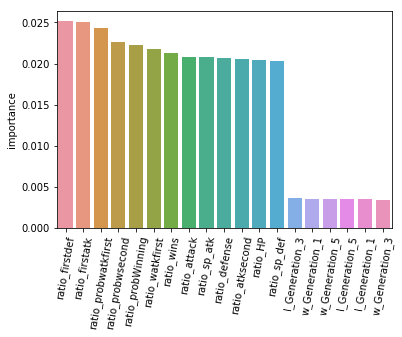

In [23]:
    feature_importance = feature_importance.sort_values(["importance"], ascending=False)
    g = sns.barplot(x=feature_importance.index[1:20], y=feature_importance['importance'][1:20])
    g.set_xticklabels(g.get_xticklabels(), rotation=80)

## Using Logistic Regression

In [24]:
    X = training_set.drop(["win_by_first"],1)
    Y = training_set["win_by_first"]

In [25]:
    C_values = [0.001, 0.01, 0.1, 1, 10, 100]

    for i in C_values:
        model1 = LogisticRegression(random_state=42, penalty="l2", C=i)
        model1.fit(X,Y)
        training_pred = model1.predict(training_set.drop(["win_by_first"],1))
        training_prediction = accuracy_score(training_set["win_by_first"], training_pred)
        valid_pred = model1.predict(valid_set.drop(["win_by_first"],1))
        valid_prediction = accuracy_score(valid_set["win_by_first"], valid_pred)

        print("Accuracy on the training set with", i," is:",   round(training_prediction,2))
        print("Accuracy on the validation set with", i," is:", round(valid_prediction,2))

Accuracy on the training set with 0.001  is: 0.56
Accuracy on the validation set with 0.001  is: 0.54
Accuracy on the training set with 0.01  is: 0.78
Accuracy on the validation set with 0.01  is: 0.77
Accuracy on the training set with 0.1  is: 0.88
Accuracy on the validation set with 0.1  is: 0.86
Accuracy on the training set with 1  is: 0.9
Accuracy on the validation set with 1  is: 0.88
Accuracy on the training set with 10  is: 0.91
Accuracy on the validation set with 10  is: 0.89
Accuracy on the training set with 100  is: 0.91
Accuracy on the validation set with 100  is: 0.89


In [26]:
    C_values = [7,9,10,12,14]

    for i in C_values:
        model1 = LogisticRegression(random_state=42, penalty="l2", C=i)
        model1.fit(X,Y)
        training_pred = model1.predict(training_set.drop(["win_by_first"],1))
        training_prediction = accuracy_score(training_set["win_by_first"], training_pred)
        valid_pred = model1.predict(valid_set.drop(["win_by_first"],1))
        valid_prediction = accuracy_score(valid_set["win_by_first"], valid_pred)

        print("Accuracy on the training set with", i," is:",   round(training_prediction,2))
        print("Accuracy on the validation set with", i," is:", round(valid_prediction,2))

Accuracy on the training set with 7  is: 0.91
Accuracy on the validation set with 7  is: 0.88
Accuracy on the training set with 9  is: 0.91
Accuracy on the validation set with 9  is: 0.89
Accuracy on the training set with 10  is: 0.91
Accuracy on the validation set with 10  is: 0.89
Accuracy on the training set with 12  is: 0.91
Accuracy on the validation set with 12  is: 0.89
Accuracy on the training set with 14  is: 0.91
Accuracy on the validation set with 14  is: 0.89


### The best logistic regression model includes an L2 penalty term of C=7

## Using Gaussian Naives Bayes

In [27]:
    from sklearn.naive_bayes import GaussianNB
    model_GNB = GaussianNB()
    model_GNB.fit(X, Y)
    print("Accuracy for the training set is:", round(model_GNB.score(X,Y),2))

    valid_GNB = model_GNB.score(valid_set.drop(["win_by_first"],1), valid_set["win_by_first"])
    print("Accuracy for the training set is:", round(valid_GNB,2))

Accuracy for the training set is: 0.87
Accuracy for the training set is: 0.85


## Using K-Nearest Neighbors

In [28]:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X, Y)
    print("Accuracy on the training set is:", round(knn.score(X, Y),2))
    print("Accuracy on the validation set is:", round(knn.score(valid_set.drop(["win_by_first"],1), valid_set["win_by_first"]),2))


Accuracy on the training set is: 1.0
Accuracy on the validation set is: 0.99


## Using Support Vector Machine

In [29]:
    model2 = SVC(random_state=42, kernel="linear")
    model2.fit(X,Y)
    training_pred = model2.predict(training_set.drop(["win_by_first"],1))
    training_prediction = accuracy_score(training_set["win_by_first"], training_pred)
    valid_pred = model2.predict(valid_set.drop(["win_by_first"],1))
    valid_prediction = accuracy_score(valid_set["win_by_first"], valid_pred)

    print("Accuracy on the training set is:",   round(training_prediction,2))
    print("Accuracy on the validation set is:", round(valid_prediction,2))

Accuracy on the training set is: 0.91
Accuracy on the validation set is: 0.9


In [30]:
    from sklearn.metrics import classification_report
    print(classification_report(valid_set["win_by_first"], valid_pred_rf, labels=None, target_names=["-1","1"]))

             precision    recall  f1-score   support

         -1       0.91      0.97      0.94      5184
          1       0.96      0.90      0.93      4816

avg / total       0.94      0.94      0.94     10000

